<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/colab/Buckley_Leverett_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 水油置換問題（Buckley-Leverettの解法）

***Buckley and Leverett (1941)*** では、多孔質媒体の油を水で置換するときの挙動について、一次元／非圧縮／非混和条件を仮定すると解析的に求められることが示されている。

まず、この問題における水の質量保存式は示す．

$$
\frac{\partial S_w}{\partial t_D} + \frac{\partial f_w}{\partial x_D} = 0 
$$

ここで，$S_w$は水飽和率，$f_w$は水のフラクショナルフロー，$x_D$は無次元長さ，$t_D$は無次元時間である．$x_D$および$t_D$は，以下のように表される．

$$x_D = \frac{x}{L}$$

$$t_D = \int_0^t \frac{u}{\phi L} dt = \frac{qt}{V_p}$$

ここで，$x$は流入面からの距離，$L$は流入面-流出面間の距離，$t$は時間，$u$はダルシー流速，$\phi$は孔隙率，$q$は流量，$V_p$は孔隙体積である．従って，$t_D$は圧入量をPV単位で表したものとなる．

**Buckley-Leverettの解法** を使って、この質量保存式から，ある時間に対する飽和率分布を解析的に求めたいと思う．

参考文献:

*   Buckley S and Leverett M, *Mechanism of Fluid Displacement in Sands*, 1941.
*   Welge H, *A Simplified Method for Computing Oil Recovery by Gas or Water Drive*, 1952.




**ライブラリのインポート**

In [0]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore');

## 相対浸透率モデル

ここでは，Coreyタイプの相対浸透率モデルを使用することにする．水の相対浸透率 $k_{rw}$ およびは油の相対浸透率 $k_{ro}$ は次のとおりモデル化する．

$$
k_{rw} = k_{rw}^0 \left( \frac{S_w - S_{wc}}{1 - S_{wc} - S_{or}} \right) ^ {n_w} 
$$

$$
k_{ro} = k_{ro}^0 \left( \frac{S_o - S_{or}}{1 - S_{wc} - S_{or}} \right) ^ {n_o}
$$

ここで，$k_{rw}^0$ はエンドポイントの水相対浸透率，$S_{wc}$ は connate water saturation，$S_{or}$ は残留油飽和率，$n_w$ は.形状パラメータでである．同様に， $k_{ro}^0$ はエンドポイント油相対浸透率，$n_o$ は形状パラメータです．両式のカッコ内はそれぞれ流動可能な容積で正規化された飽和率である．

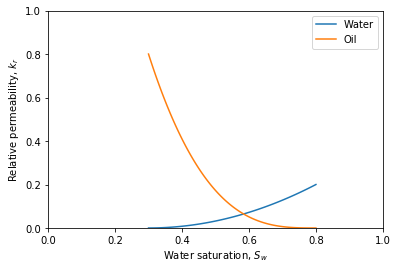

In [2]:
Swc = 0.3 # Vol/Vol, Connate water saturation
Sor = 0.2 # Vol/Vol, Residual oil saturation
krw0 = 0.2 # Water endpoint relative permeability at residual oil saturation
kro0 = 0.8 # Oil endpoint relative permeability at connate water saturation
nw = 2 # Exponent for water relative permeability
no = 3 # Exponent for oil relative permeability

# Water saturation and normalized water saturation
Sw = np.linspace(start=Swc, stop=1-Sor, num = 100)
Swn = (Sw-Swc) / (1-Swc-Sor)

# Relative permeability model
def relperm(Sn, kr0, n):
    kr = kr0 * Sn ** n
    return kr

krw = relperm(Sn=Swn, kr0=krw0, n=nw) # Water
kro = relperm(Sn=1-Swn, kr0=kro0, n=no) # Oil

# Plot
plt.plot(Sw, krw, label='Water')
plt.plot(Sw, kro, label='Oil')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Relative permeability, $k_r$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

各パラメータはWater wetな相対浸透率になるように適当に設定して進める．よく見る形の相対浸透率ができている．

## フラクショナルフロー

**重力と毛細管圧力の影響が無視できるとき**，水と油のフラクショナルフローは下記のとおりとなる．

$$
f_w = \frac{\lambda_w}{\lambda_t}, \ \ \ 
f_o = \frac{\lambda_o}{\lambda_t} 
$$

ここで，$\lambda_w$，$\lambda_o$，$\lambda_t$ はそれぞれ水，油，両相のモビリティを示し，下記のように計算される．

$$
\lambda_w = \frac{k \ k_{rw}}{\mu_w}, \ \ \ 
\lambda_o = \frac{k \ k_{ro}}{\mu_o}, \ \ \
\lambda_t = \lambda_w + \lambda_o
$$

従って，$f_w$は下記のとおり表される．

$$
f_w = \frac{\lambda_w}{\lambda_t} 
= \frac{1}{1+ \frac{k_{ro}}{\mu_o}   / \frac{k_{rw}}{\mu_w} }
$$


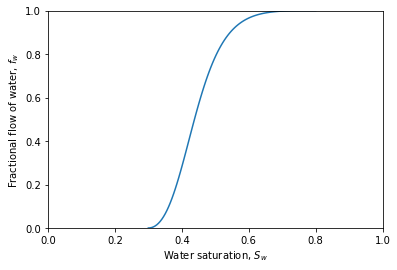

In [3]:
# Viscosity
muw = 0.5 # cP, Water
muo = 10 # cP, Oil

# Fractional flow of water
# fw = 1 / (1 + (kro/oil_viscosity) / (krw/water_viscosity))
fw = (krw/muw) / (krw/muw + kro/muo) # To avoid division by zero

# Plot
plt.plot(Sw, fw)
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Fractional flow of water, $f_w$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

水のフラクショナルフローは、$S_w = S_{wc}$ で0から立ち上がり、$S_w = 1-S_{or}$で1になるS字型の曲線となった．
相対浸透率は飽和率のみの関数なので，粘度が飽和率によらないとすると，フラクショナルフロー関数も飽和率のみの関数となる．

## Buckley-Leverettの解法

***Buckley and Leverett (1941)*** では，水の質量保存式から以下の関係式を導いている．

$$\frac{df_w}{dS_w} = \left. \frac{dx_D}{dt_D} \right|_{S_w} = v_D$$

この式は，**ある飽和率$S_w$は一定の速度$v_D$（Wave velocity）で進む**ということを示している．
水のフラクショナルフロー$f_w$を微分して、$v_D$を求めてみる．


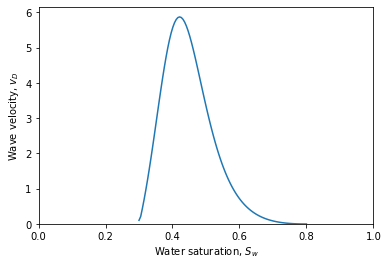

In [4]:
# Wave velocity = Derivative of fractional flow of water
vD = np.gradient(fw, Sw)

# Plot
plt.plot(Sw, vD)
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Wave velocity, $v_D$')
plt.xlim(0, 1)
plt.ylim(0,)
plt.show()

水飽和率$S_w$に対する$v_D$が求められた．この速度で各飽和率が初期条件から進展することになる．

では，ある$t_D$のときの飽和率分布を考えてみる．ある飽和率$S_w$のフロントは，一定の速度$v_D$で進みむから，その位置$x_D$は圧入時間$t_D$と$v_D(S_w)$の積となる．例えば，$t_D=0.1 PV$のときの飽和率分布は以下のようになる．


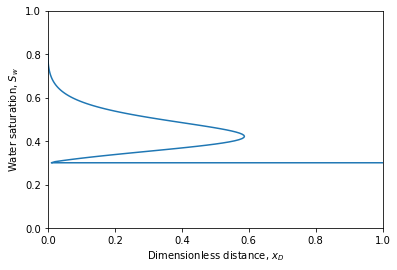

In [5]:
tD = 0.1 # PV injected
xD = vD * tD

# Plot
plt.plot([1,*xD], [Swc,*Sw]) # Added connate water saturaion
plt.xlabel('Dimensionless distance, $x_D$')
plt.ylabel('Water saturation, $S_w$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

この飽和率分布は正しくない．飽和率の高いフロント（例えば，$S_w=0.5$）が，飽和率の低いフロント（例えば，$S_w=0.35$）を追い越している．
物理現象に反しており，実際には生じ得ない現象である．このとき，実際には**ショックフロント**が形成され，ピストン状の置換が進行することとなる．

### ショックフロント

ショックフロントの位置を決めるために，次の物理的な制約を課す．

*   **Velocity consraint:** Wave velocities in the two phase region must decrease monotonically for zones in which compositions vary continuously as the solution composition path is traced from down stream compositions to upstream compositions.
*   **Entropy condition:** Wave velocities on the upstream side of the shock must be greater than (or equal to) the shock velocity and wave velocities on the down stream side must be less than (or equal to) the shock velocity.

この制約のもと，フラクショナルフロー関数上で初期条件からの接線としてショックフロントは幾何的に決定される（***Welge (1952)***）．Method of characteristicsの考えでも決定できる．




Dimensionless Shock Front velocity: 3.959
Shock Front water saturation: 0.487


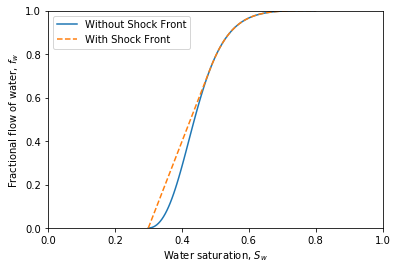

In [6]:
slope_fw = (fw - 0) / (Sw - Swc)  # Warning: slope_fw[0] = nan

vD_sf = np.nanmax(slope_fw) # Shock Front velocity
Sw_sf = Sw[np.nanargmax(slope_fw)] # Shock Front water saturation

# Dimensionless velocity with Shock Front
vD[Sw<Sw_sf] = vD_sf

# Fractional flow of water with Shock Front
fw_wSF = np.where(Sw<=Sw_sf, vD_sf*(Sw-Swc), fw)

print()
print('Dimensionless Shock Front velocity: {0:.3f}'.format(vD_sf))
print('Shock Front water saturation: {0:.3f}'.format(Sw_sf))

# Plot
plt.plot(Sw, fw, label='Without Shock Front')
plt.plot(Sw, fw_wSF, '--', label='With Shock Front')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Fractional flow of water, $f_w$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### ある時間の飽和率分布

ショックフロントを考慮した速度が得られたので，適当な時間ごとの飽和率分布をみてみる．無次元時間は，0.1, 0.2, 0.3, 0.5, 1.0を選んだ。

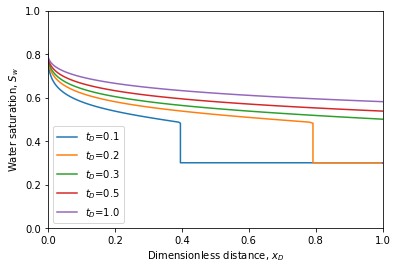

In [7]:
for tD in [0.1, 0.2, 0.3, 0.5, 1.0]:
    xD = vD * tD
    plt.plot([1, *xD], [Swc, *Sw], label='$t_D$='+str(tD))

# Plot
plt.xlabel('Dimensionless distance, $x_D$')
plt.ylabel('Water saturation, $S_w$')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

ショックフロントが進展していく様子がみられる．ショックフロント前後で水飽和率は$S_{wc}$から$S_w=0.487$へと非連続的に変化している．$t_D=0.3$のタイミングで，ショックフロントはすでに流出面に到達（ブレークスルー）している．

ブレークスルーする時間（Dimensionless time at breakthrough） $t_{D, BT} $ [PV] は，ショックフロントが流出側に到達する時間である．

$$ t_{D, BT} = \frac{1}{v_{D, sf}}$$

In [8]:
tD_BT = 1/vD_sf
print('Dimensionless time at Breakthrough: {0:.3f} PV'.format(tD_BT))

Dimensionless time at Breakthrough: 0.253 PV


### 多孔質媒体内の平均水飽和率の時間変化

多孔質媒体全体の平均水飽和率 $\bar{S_w}$ は下記のとおり表される．

$$
\bar{S_w} =
        \begin{cases}
            S_{wc} + t_D \quad \quad  \quad & t_D \le t_{D, BT}  \\
            S_{w, out} - \frac{f_{w, out} - 1}{f'_{w, out} }  \quad & otherwise \\
        \end{cases}
$$

ここで，$S_{w, out}$ は流出面での水飽和率，$f_{w, out}$ は流出面での水のフラクショナルフロー， $f'_{w, out} $ ($=v_{D,out}=1/{t_D}$) はその微分値である．流出面での水の飽和率とフラクショナルフローは，$v_D$の関数として数値的に求めることにした．

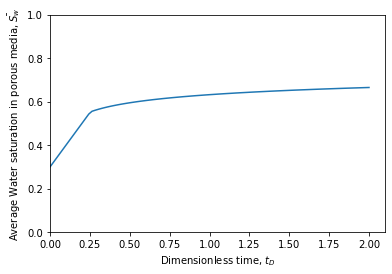

In [9]:
# Dimensionless time for plotting
tD = np.linspace(start=0, stop=2, num = 100)

# Water saturation at outlet
f = interpolate.interp1d(vD, Sw, kind='linear', bounds_error=False)
Sw_out = np.where(tD<=tD_BT, Swc, f(1/tD))

# Fractional flow of water at outlet
f = interpolate.interp1d(vD, fw, kind='linear', bounds_error=False)
fw_out = np.where(tD<=tD_BT, 0, f(1/tD))

# Average water saturation in porous media
Sw_ave = np.where(tD<=tD_BT, Swc+tD, Sw_out-(fw_out-1)/(1/tD))

# Plot
plt.plot(tD, Sw_ave)
plt.xlabel('Dimensionless time, $t_D$')
plt.ylabel('Average Water saturation in porous media, $\\bar{S_w}$')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

多孔質媒体内の平均水飽和率は，初期条件$S_{wc}$から水の圧入に伴ってブレークスルーまで線形に増加する．ブレークスルー後は水も流出し始めるため，平均水飽和率の増加は緩やかになった．

### 油の回収量の時間変化

油の回収量 $N$ [PV] は下記のように表される．

$$
N =
        \begin{cases}
            t_{D} \quad \quad & t_D \le t_{D, BT}  \\
            \bar{S_w} - S_{wc}  \quad & otherwise \\
        \end{cases}
$$

なお，ブレークスルー時は下記のとおりとなる．

$$N_{BT} =  t_{D, BT} $$

Oil recovery volume at Breakthrough: 0.253 PV


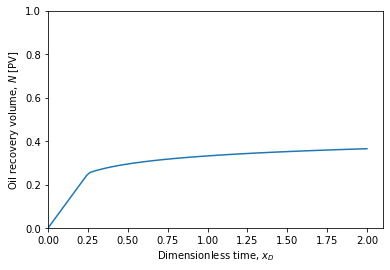

In [10]:
N = np.where(tD<=tD_BT, tD, Sw_ave-Swc)

N_BT = tD_BT
print('Oil recovery volume at Breakthrough: {0:.3f} PV'.format(N_BT))

# Plot
plt.plot(tD, N, )
plt.xlabel('Dimensionless time, $x_D$')
plt.ylabel('Oil recovery volume, $N$ [PV]')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

油の回収量も平均水飽和率と似た挙動となる．ゼロから水の圧入に伴ってブレークスルーまで線形に増加した後，緩やかに増加する挙動となった．

### 油回収率の時間変化

油の回収率 $RF$ [HCPV] は下記のように表される．

$$
{RF} = \frac{N}{1-S_{wc}}
$$

ブレークスルー時は下記のとおりとなる．

$$
{RF}_{BT} = \frac{N_{BT}}{1-S_{wc}}
$$

Oil recovery factor at Breakthrough: 0.361 HCPV


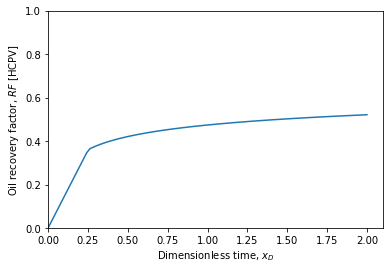

In [11]:
RF = N / (1 - Swc)

RF_BT = N_BT / (1 - Swc) 
print('Oil recovery factor at Breakthrough: {0:.3f} HCPV'.format(RF_BT))

# Plot
plt.plot(tD, RF)
plt.xlabel('Dimensionless time, $x_D$')
plt.ylabel('Oil recovery factor, $RF$ [HCPV]')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

油の回収率もゼロから水の圧入に伴ってブレークスルーまで線形に増加した後，緩やかに増加する挙動となる．ブレークスルーが起きると，その後の油の回収率の増加は緩やかになるため，なるべくブレークスルーを遅らせ，綺麗なピストンライクな置換が良い置換となると考えられる．

*End of notebook...*